In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import preprocessing
from utils.functions import *
le = preprocessing.LabelEncoder()

In [5]:
base = pd.read_csv("./data/data_modelagem.csv")
base = base.drop(columns=['State', 'Unnamed: 0'])
base = base.rename(columns={'%_de_extremamente_pobres_':"%_ext_pob",'idhm_ajustado_à_desigualdade_':'idhm_desigualdade'})

A Tabela (Descritiva) apresenta os resultados descritivos das variáveis em estudo. Nela a variável renda per capita apresentou mínimo de 264, média de 702, e máximo de 1498, levando em conta que o quantil 75% apresenta 847 de renda per capita, é uma diferença grande do máximo para esse valor. Para a porcentagem de extrema pobraza, temos média de 6.85%. Considerando as variáveis IDHM para Educação, Longevidade e Desigualdade, temos médias de 0.7336, 0.8359 e 0.5870, respectivamente. Por fim, a Área apresenta média de 315216, aproximadamente. 

In [6]:
base.iloc[0:27,:].describe()

,renda_per_capita_,%_ext_pob,população_total_,idhm_educação_,idhm_longevidade_,idhm_desigualdade,Area
count,27.000000,27.000000,2.700000e+01,27.000000,27.000000,27.000000,2.700000e+01
mean,702.846667,6.851852,7.759128e+06,0.733630,0.835889,0.587037,3.152156e+05
std,264.649058,4.578216,9.256985e+06,0.053191,0.043178,0.064692,3.751019e+05
min,366.240000,1.300000,5.397410e+05,0.639000,0.773000,0.500000,5.760783e+03
25%,516.330000,2.550000,2.861026e+06,0.698000,0.799000,0.535000,7.609908e+04
50%,598.770000,6.720000,3.996784e+06,0.735000,0.828000,0.566000,2.242738e+05
75%,847.060000,10.570000,9.314394e+06,0.770000,0.874500,0.638500,3.348839e+05
max,1498.740000,17.310000,4.591267e+07,0.849000,0.916000,0.705000,1.559168e+06


Na Figura (correlação) são apresentados as correlações entre as variáveis quantitativas em estudo. Observando a variável do idhm para desigualdade, nota-se que esta variável apresenta correlações fortes com praticamente todas as outras variáveis. Mesmo apresentando correlação forte com a variável resposta renda per capita, ela causará problemas de autocorrelação entre os dados. Portando, não usaremos na modelagem. Já considerando as outras variáveis explicativas, nenhuma delas apresentam correlações muito elevadas entre elas. Olhando para a variável resposta, apenas a população total e a área não apresentam correlações fortes com ela.

Percebe-se também que a porcentagem de extrema pobreza possui correlação negativa com a variável resposta, ou seja, diminui a porcentagem de extrema pobreza conforme o aumento da renda per capita do local. Já para as demais variáveis explicativas, com exceção da área, todas apresentam correlação positiva, conforme aumento da renda per capita, tbm há um aumento em seus índices.

/tmp/ipykernel_78054/4239505012.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(base.iloc[0:27, :].corr(), annot=True,cmap='RdYlBu')


<AxesSubplot: >

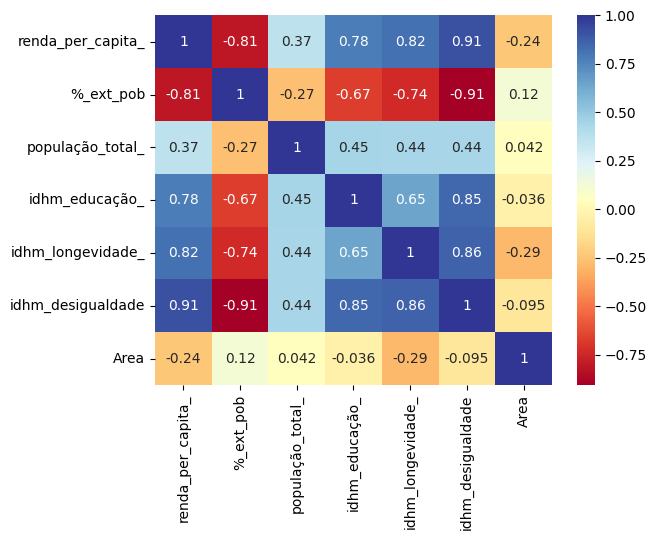

In [7]:
# Teria que ver se é mais coerente usar todas as observações, ou limitalas, acabei deixando só com a base de treino 
# Porcentagem de extrema pobreza tbm tem bastante correlação com os idhm, mas não retirei, fica 90 r2 retirando pelo lgbm
sns.heatmap(base.iloc[0:27, :].corr(), annot=True,cmap='RdYlBu')

Analizando a Figura (Boxplot), as regiões Norte e Nordeste apresentam as menores rendas per capita. Na região nordeste vemos um outlier, sendo o estado de Maranhão. Para as regiões Centro-Oeste, Sudeste e Sul, a renda per capita são mais elevedas, com a região Centro-Oeste apresentando um outlier, sendo o Distrito Federal. 

<AxesSubplot: xlabel='Region', ylabel='renda_per_capita_'>

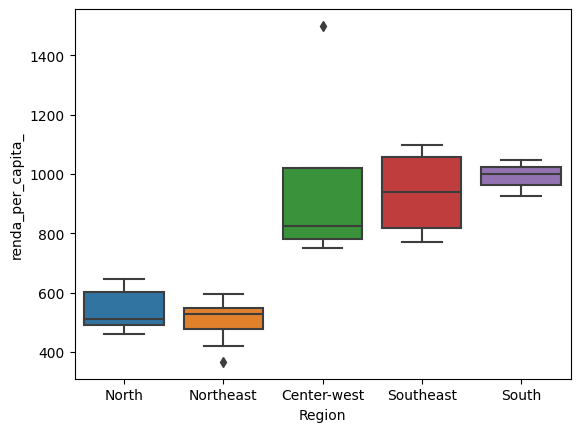

In [8]:
# Acredito que o boxplot fica melhor que barras, ja da para ver outliers alem da diferença de renda de cada regiao
sns.boxplot(x='Region', y='renda_per_capita_', data=base.iloc[0:27, :])

Pela Figura (Disperção 1) são apresentados diagramas de disperção para as variáveis porcentagem de extrema pobreza e população total com a variável resposta renda per capita, separadas pelas regiões. Então, percebe-se que as maiores porcentagens de extrema pobreza estão na região nordeste, aumentando conforme a diminuição da renda percapita. Já os menores índices de pobreza estão nas regiões Centro-Oeste, Sudeste e Sul, com a região Centro-Oeste apresentando a maior renda per capita, no Distrito Federal. 

Olhando para a população total, no Distrito Federal mesmo apresentando uma população não tão expressiva, ainda contém a maior renda per capita. As regiões do Sudeste apresentaram as maiores quantidades de pupulação. Nordeste e Norte com as menores pupulações e renda per capita, como visto acima.

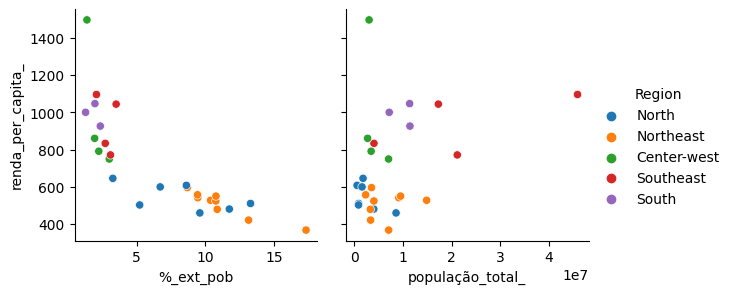

In [9]:
# sns.barplot(data=base.iloc[0:27, :], x='Region', y='renda_per_capita_')
# sns.scatterplot(x="%_ext_pob", y="renda_per_capita_",hue='Region', data=base.iloc[0:27, :])
sns.PairGrid(data=base.iloc[0:27,:],y_vars=['renda_per_capita_'],x_vars=["%_ext_pob","população_total_"]
,hue='Region',height=3).map(sns.scatterplot).add_legend()


Observando a Figura (Disperção 2), no qual são apresentados diagramas de disperção para as variáveis IDHM Educação e IDHM Longevidade com a variável resposta renda per capita, separadas pelas regiões. Nstas duas variáveis o comportamento é muito similar, com o Distrito Federal apresentando índices bem elevados dos IDHM. Junto com algumas regiões do Sudeste e Sul.

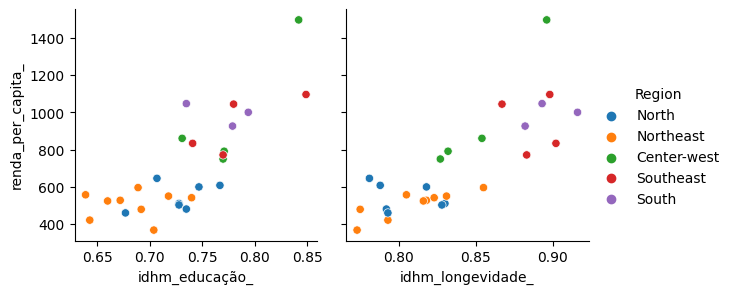

In [10]:
sns.PairGrid(data=base.iloc[0:27,:],y_vars=['renda_per_capita_'],x_vars=['idhm_educação_','idhm_longevidade_']
,hue='Region',height=3).map(sns.scatterplot).add_legend()

In [11]:
# Essa dos estados nã osei se tem necessidade, pq estamos lidando por região, isso daqui nem vai para a modelagem
# sns.barplot(x='renda_per_capita_',y="territorialidade", data=base.iloc[0:27, :],  
#             order=base.iloc[0:27, :].sort_values('renda_per_capita_',ascending = False).territorialidade.iloc[0:10])

In [12]:
dummies = pd.get_dummies(base['Region'])
base[dummies.columns] = dummies

In [13]:
base = base.drop(columns=['Region','idhm_desigualdade'])

In [14]:
treino = base.iloc[0:27, :].drop(columns=['territorialidade'])
teste = base.iloc[27:54, :].drop(columns=['territorialidade'])
val = base.iloc[54:81, :].drop(columns=['territorialidade'])

In [15]:
y_treino = treino['renda_per_capita_']
y_teste = teste['renda_per_capita_']
y_val = val['renda_per_capita_']
treino = treino.drop(columns=['renda_per_capita_'])
teste = teste.drop(columns=['renda_per_capita_'])
val = val.drop(columns=['renda_per_capita_'])

In [16]:
def search_space(model):
    model = model.lower()
    space = {}
    if model == 'dt':
        space = {
            'min_samples_leaf': hp.randint('min_samples_leaf', 1,50),
            'max_depth': hp.randint('max_depth', 1,25),
            'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
            'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 1)
            }
    elif model == 'lasso':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 10),
            'warm_start' : hp.choice('warm_start', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000))
            }
    elif model == 'ridge':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 500),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000)),
            'solver' : hp.choice('solver', ['svd', 'sag', 'saga', 'lbfgs', 'auto']),
            }
    elif model == 'linear':
         space = {
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            }
    elif model == 'elastic':
        space = {
            'alpha' : hp.uniform('alpha', 0.00001, 100),
            'l1_ratio' : hp.uniform('l1_ratio', 0, 1),
            'warm_start' : hp.choice('warm_start', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'max_iter' : hp.choice('max_iter', range(100,1000)),
            }
    elif model == 'rf':
        space = {
                'min_samples_leaf': hp.randint('min_samples_leaf', 1,50),
                'max_depth': hp.randint('max_depth', 1,20),
                'n_estimators': hp.randint('n_estimators', 50,1000),
                'max_leaf_nodes' : hp.randint('max_leaf_nodes', 2,100),
                'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.3)
            }
    elif model == 'lgbm':
        space = {
            'num_leaves':  hp.randint('num_leaves', 1,50),
            'max_depth': hp.randint('max_depth', 1,20),
            'feature_fraction':  hp.uniform('feature_fraction', 0.2, 0.5),
            'subsample':  hp.uniform('subsample', 0.2, 1),
            'bagging_fraction':  hp.uniform('bagging_fraction', 0.5, 0.9),    
            'learning_rate':  hp.uniform('learning_rate', 0.001, 0.1),
            'lambda_l1':  hp.uniform('lambda_l1', 0.0001, 1),
            'lambda_l2':  hp.uniform('lambda_l2', 0.0001, 1),
            'min_child_samples': hp.randint('min_child_samples', 1,50),
            'n_estimators': hp.randint('n_estimators', 50,1000),
            'colsample_bytree':  hp.uniform('colsample_bytree', 0.1, 1)  
            }
    elif model == 'xgb':
        space={
                'max_depth': hp.choice('max_depth', range(1,20)),
                'learning_rate':  hp.uniform('learning_rate', 0.001, 0.1),
                'gamma': hp.uniform ('gamma', 1,9),
                'min_child_samples': hp.choice('min_child_samples', range(1,50)),
                'subsample':  hp.uniform('subsample', 0.2, 1),
                'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
                'reg_lambda' : hp.uniform('reg_lambda', 0,1),
                'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
                'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
                'n_estimators': hp.choice('n_estimators', range(50,1000)),
                'parallel_tree': hp.uniform ('parallel_tree', 1,10),
            }
    space['model'] = model
    return space

In [17]:
models = {
            'dt' : DecisionTreeRegressor,
            'rf' : RandomForestRegressor,
            'xgb' : XGBRegressor,
            'lgbm' : LGBMRegressor ,
            'lasso' : Lasso,
            'elastic' : ElasticNet,
            'ridge' : Ridge,
            'linear' : LinearRegression
        }

In [18]:
def get_acc_status(clf,X_,y):
    acc = cross_val_score(clf, X_, y, cv=5, scoring="neg_root_mean_squared_error").mean()
    display(clear=True)
    return {'loss': -acc, 'status': STATUS_OK}

def obj_fnc(params):
    print(type(params.get('model')), '---')
    model = params.get('model').lower()
    del params['model']
    clf = models[model](**params)
    display(clear=True)
    return(get_acc_status(clf,treino,y_treino))

In [20]:
best_params = {}
hypopt_trials = {}

for model in models:
    hypopt_trials[model] = Trials()
    best_params[model] = fmin(obj_fnc, search_space(model), algo=tpe.suggest,
    max_evals=50, trials= hypopt_trials[model])
    print(best_params[model])
    print(hypopt_trials[model].best_trial['result']['loss'])

[LightGBM] [Warning] lambda_l1 is set=0.017063038392094193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017063038392094193
[LightGBM] [Warning] feature_fraction is set=0.3591130440629549, colsample_bytree=0.10096396272568764 will be ignored. Current value: feature_fraction=0.3591130440629549
[LightGBM] [Warning] lambda_l2 is set=0.5330509805427519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5330509805427519
[LightGBM] [Warning] bagging_fraction is set=0.6079681304257732, subsample=0.669962625475321 will be ignored. Current value: bagging_fraction=0.6079681304257732
[LightGBM] [Warning] lambda_l1 is set=0.017063038392094193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017063038392094193
[LightGBM] [Warning] feature_fraction is set=0.3591130440629549, colsample_bytree=0.10096396272568764 will be ignored. Current value: feature_fraction=0.3591130440629549
[LightGBM] [Warning] lambda_l2 is set=0.5330509805427519, reg_lambda=0.0 will be ignored. C

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

job exception: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vitorbsp/.local/l

 52%|█████▏    | 26/50 [00:15<00:14,  1.67trial/s, best loss: 120.7108792038711]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vitorbsp/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vitorbsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/home/vitorbsp/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/home/vitorbsp/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/home/vitorbsp/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py", line 2605, in __init__
    train_set.construct()
  File "/home/vitorbsp/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py", line 1815, in construct
    self._lazy_init(self.data, label=self.label,
  File "/home/vitorbsp/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py", line 1538, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/home/vitorbsp/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py", line 1659, in __init_from_np2d
    _safe_call(_LIB.LGBM_DatasetCreateFromMat(
  File "/home/vitorbsp/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py", line 125, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode('utf-8'))
lightgbm.basic.LightGBMError: Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



In [ ]:
for model in best_params:
    if model == 'rf':
        crit = {0: 'gini', 1:  'entropy', 2: 'log_loss'}
        feat = {0: 'sqrt', 1: 'log2', 2: None}

        trainedforest = RandomForestRegressor(
                                            min_samples_leaf = best_params[model]['min_samples_leaf'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            min_impurity_decrease = best_params[model]['min_impurity_decrease'], 
                                            max_leaf_nodes = best_params[model]['max_leaf_nodes'], 
                                            n_estimators = best_params[model]['n_estimators']
                                            ).fit(treino, y_treino)

    elif model == 'xgb':
         trainedxgb = XGBRegressor(learning_rate = best_params[model]['learning_rate'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            gamma = best_params[model]['gamma'],
                                            min_child_samples = best_params[model]['min_child_samples'],
                                            subsample = best_params[model]['subsample'], 
                                            reg_alpha = best_params[model]['reg_alpha'],
                                            reg_lambda = best_params[model]['reg_lambda'],
                                            colsample_bytree = best_params[model]['colsample_bytree'], 
                                            min_child_weight = best_params[model]['min_child_weight'], 
                                            parallel_tree = best_params[model]['parallel_tree'], 
                                            n_estimators = best_params[model]['n_estimators']
                                            ).fit(treino, y_treino)
    elif model == 'lgbm':
         trainedlgbm = LGBMRegressor(learning_rate = best_params[model]['learning_rate'], 
                                            max_depth = best_params[model]['max_depth'], 
                                            num_leaves = best_params[model]['num_leaves'],
                                            subsample = best_params[model]['subsample'], 
                                            colsample_bytree = best_params[model]['colsample_bytree'], 
                                            feature_fraction = best_params[model]['feature_fraction'], 
                                            bagging_fraction = best_params[model]['bagging_fraction'], 
                                            n_estimators = best_params[model]['n_estimators'],
                                            lambda_l1 = best_params[model]['lambda_l1'],
                                            lambda_l2 = best_params[model]['lambda_l2'],
                                            min_child_samples = best_params[model]['min_child_samples']
                                            ).fit(treino, y_treino)

    elif model == 'dt':
        feat = {0: 'sqrt', 1: 'log2', 2: None}
        trainedtree = DecisionTreeRegressor(
                                            max_depth = best_params[model]['max_depth'], 
                                            max_features = feat[best_params[model]['max_features']], 
                                            min_samples_leaf = best_params[model]['min_samples_leaf'], 
                                            min_impurity_decrease = best_params[model]['min_impurity_decrease']).fit(treino, y_treino)
    elif model == 'lasso':
        booleano = {0 : True, 1 : False}

        trainedlasso = Lasso(
                                            alpha=best_params[model]['alpha'],
                                            warm_start = booleano[best_params[model]['warm_start']],
                                            tol = best_params[model]['tol'],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'ridge':
        booleano = {0 : True, 1 : False}
        solver = {0: 'svd', 1: 'sag', 2: 'saga', 3 : 'lbfgs', 4 : 'auto'}
        trainedridge = Ridge(
                                            alpha=best_params[model]['alpha'],
                                            tol = best_params[model]['tol'],
                                            solver = solver[best_params[model]['solver']],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'elastic':
        booleano = {0 : True, 1 : False}
        trainedelastic = ElasticNet(
                                            l1_ratio=best_params[model]['l1_ratio'],
                                            alpha=best_params[model]['alpha'],
                                            warm_start = booleano[best_params[model]['warm_start']],
                                            tol = best_params[model]['tol'],
                                            max_iter = best_params[model]['max_iter']).fit(treino, y_treino)
    elif model == 'linear':
        booleano = {0 : True, 1 : False}
        trainedlinear = LinearRegression(fit_intercept = booleano[best_params[model]['fit_intercept']]).fit(treino, y_treino)


[11:30:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_child_samples", "parallel_tree" } are not used.

[LightGBM] [Warning] feature_fraction is set=0.4054921786709433, colsample_bytree=0.9907213944139123 will be ignored. Current value: feature_fraction=0.4054921786709433
[LightGBM] [Warning] lambda_l1 is set=0.7071809657838658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7071809657838658
[LightGBM] [Warning] bagging_fraction is set=0.6544557311901075, subsample=0.5149439607073554 will be ignored. Current value: bagging_fraction=0.6544557311901075
[LightGBM] [Warning] lambda_l2 is set=0.4039403138411552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4039403138411552


In [19]:
def regression_metrics(model):
    y_pred = model.predict(val)
    metrics = [r2_score(y_val, y_pred), mean_absolute_error(y_val,y_pred), np.sqrt(mean_squared_error(y_val, y_pred)),mean_absolute_percentage_error(y_val, y_pred)]
    return metrics

In [ ]:
trained_models = {
            'dt' : trainedtree,
            'rf' : trainedforest,
            'xgb' : trainedxgb,
            'lgbm' : trainedlgbm ,
            'lasso' : trainedlasso,
            'elastic' : trainedelastic,
            'ridge' : trainedridge,
            'linear' : trainedlinear
        }

In [ ]:
metrics = pd.DataFrame()
metrics['metricas'] = ['R^2', 'MAE', 'RMSE', 'MAPE']
for model in trained_models:
    metrics[model] = regression_metrics(model)

In [20]:
run_experiment(trainedlinear)

R^2 :  0.7183346296172439
MAE : 89.64225835578293
RMSE: 119.49002650131611


In [21]:
run_experiment(trainedelastic)

R^2 :  0.7110957019383695
MAE : 86.97416740668635
RMSE: 121.01575960105663


In [22]:
run_experiment(trainedridge)

R^2 :  0.6801072518406961
MAE : 88.23866855536913
RMSE: 127.34066899801415


In [23]:
run_experiment(trainedlasso)

R^2 :  0.7064958567026202
MAE : 92.02355175998343
RMSE: 121.97534295949175


In [24]:
run_experiment(trainedxgb)

R^2 :  0.6624115573227648
MAE : 71.17881478768807
RMSE: 130.81535218557005


In [25]:
run_experiment(trainedforest)

R^2 :  0.6616862357811448
MAE : 71.76068220005952
RMSE: 130.9558076493398


In [26]:
run_experiment(trainedlgbm)

R^2 :  0.9147789819488397
MAE : 45.803975134873205
RMSE: 65.72616438559147


In [27]:
run_experiment(trainedtree)

R^2 :  0.48551365634456956
MAE : 97.00432098765431
RMSE: 161.4923132240438


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
selector = SelectKBest(score_func=f_regression, k=treino.shape[1])
selector.fit(treino, y_treino)
a = pd.DataFrame({'variables' : treino.columns, 'pvalues' : selector.pvalues_, 'lgbm' : trainedlgbm.feature_importances_, 'xgb' : trainedxgb.feature_importances_})